In [1]:
import glob
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
import gdal, ogr, os, osr
from skimage import exposure

# Importing modules for merging rasters to form a true colour image
from rasterio.merge import merge
from skimage import exposure

# Importing Machine learning modules for splitting, training, testing and classifying the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
#ImgList = glob.glob('/home/emmanuel/Desktop/PRACTICING CODE/S2A_MSIL1C_20190415T075611_N0207_R035_T35LPC_20190415T095807.SAFE/*.jp2')
ImgList = glob.glob('/home/emmanuel/Desktop/ML/L1C_T35LPC_A003922_20171206T081942/S2B_MSIL1C_20171206T080309_N0206_R035_T35LPC_20171206T114459.SAFE/GRANULE/L1C_T35LPC_A003922_20171206T081942/IMG_DATA/*B0*tif')
#shapes = glob.glob('/home/emmanuel/Desktop/BIg data Summer schoo/Sentinel2Shapes/*.shp')
shapes = glob.glob('/home/emmanuel/Desktop/ML/Sentinel2Shapes/*shp')
shapes[2]

'/home/emmanuel/Desktop/ML/Sentinel2Shapes/Clouds.shp'

In [3]:
blueband = ImgList[6]
greenband = ImgList[2]
redband = ImgList[7]
nirband = ImgList[8]

In [4]:
shapes[0]

'/home/emmanuel/Desktop/ML/Sentinel2Shapes/Bareland.shp'

In [5]:
rasterpath = ImgList[2]
rasterpath

'/home/emmanuel/Desktop/ML/L1C_T35LPC_A003922_20171206T081942/S2B_MSIL1C_20171206T080309_N0206_R035_T35LPC_20171206T114459.SAFE/GRANULE/L1C_T35LPC_A003922_20171206T081942/IMG_DATA/RT_T35LPC_20171206T080309_B03.tif'

In [6]:
blue_raster = rasterio.open(blueband)
green_raster = rasterio.open(greenband)
red_raster = rasterio.open(redband)
nir_raster = rasterio.open(nirband)

In [7]:
# quantification value; It is basically a scaling constant which allows to store the products as integers instead of 
# float to reduce the file size required to store it on a hard drive. Quantification value for L1C Sentinel2 is 0.0001
blue_array = blue_raster.read(1)
green_array = green_raster.read(1)
red_array = red_raster.read(1)
nir_array = nir_raster.read(1)
nir_array.min()

0.0

In [8]:
# Sentinel2 image cleaning function
def Sentinel2_Cleaner(raster_array):
    better_array = np.where((raster_array <= 1) & (raster_arry >= 0), raster_array, 0.0)
    return better_array

In [9]:
# Function that turns an array into a raster
def array2raster(rasterfn,newRasterfn,array):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = raster.RasterXSize
    rows = raster.RasterYSize
    driver = gdal.GetDriverByName("GTiff")
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [10]:
def IndexMaker(array1, array2):
    np.seterr(divide = 'ignore', invalid = 'ignore')
    Index = (array1 - array2)/(array1 + array2)
    return Index

In [11]:
def IndexCleaner(array):
    better_array =  np.where((array <= 1) & (array >= -1), array, 0.0)
    return better_array

In [12]:
def CreatRasters(blue_array, green_array, red_array, nir_array, rasterpath):
    NDVI = IndexMaker(nir_array, red_array)
    #NDVI = IndexCleaner(NDVI)
    array2raster(rasterpath, rasterpath[:-7] + 'NDVI.tif', NDVI)
    
    NDWI = IndexMaker(green_array, nir_array)
    #NDWI = IndexCleaner(NDWI)
    array2raster(rasterpath, rasterpath[:-7] + 'NDWI.tif', NDWI)

In [13]:
CreatRasters(blue_array, green_array, red_array, nir_array, rasterpath)
NDVI_raster = rasterio.open(rasterpath[:-7] + 'NDVI.tif')
NDWI_raster = rasterio.open(rasterpath[:-7] + 'NDWI.tif')
NDWI_array = NDWI_raster.read(1)
NDVI_array = NDWI_raster.read(1)

In [14]:
rgb = np.dstack((red_array[4000:8000, 0:4000], green_array[4000:8000, 0:4000], blue_array[4000:8000, 0:4000]))
better_rgb = exposure.rescale_intensity(rgb, in_range=(0, 0.25))

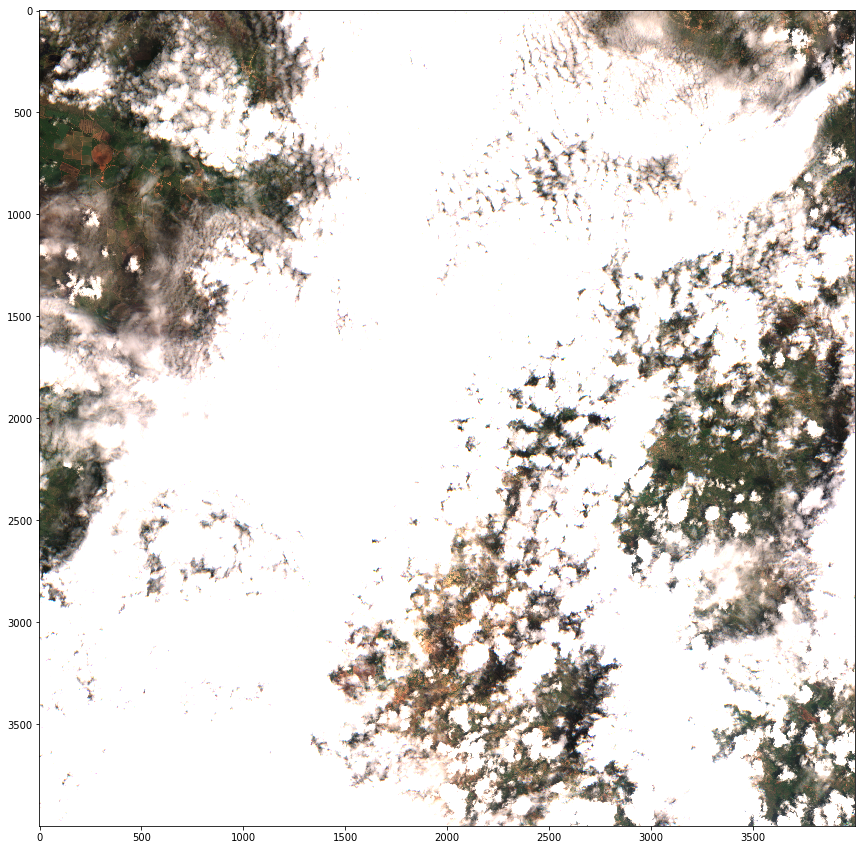

In [15]:
plt.figure(figsize = (15,15))
plt.imshow(better_rgb)
plt.savefig('TrueColor.png')

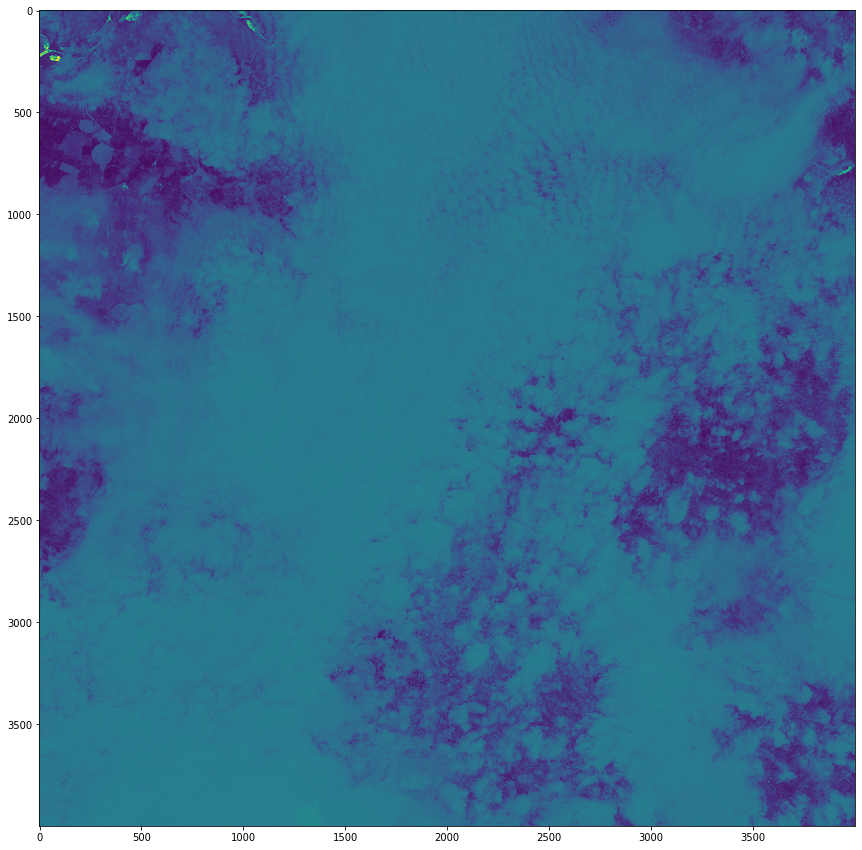

In [16]:
plt.figure(figsize = (15,15))
show(NDVI_array[4000:8000, 0:4000])

In [17]:
NDVI_array[4000:8000, 0:4000].min()

-0.83050853

In [18]:
# Get shape geometry in json format
def getFeatures(gdf):
    '''Function to parse features from GeoDataFrame in such a manner that rasterio can take them'''
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [19]:
def getClasses(shp, blue, green, red, nir, NDVI, NDWI):
    class_df = pd.DataFrame()
    df_ls = []
    geom = gpd.read_file(shp)
    geom = geom.to_crs(crs = red.crs.data)
    sa = np.arange(len(geom))
    sb = np.arange(1, len(geom)+1)
    for a, b in zip(sa, sb):
        cord1 = getFeatures(geom.iloc[a:b,:])
        out_blue, out_transform = mask(blue, cord1, crop = True)
        out_green, out_transform1 = mask(green, cord1, crop = True)
        out_red, out_transform2 = mask(red, cord1, crop = True)
        out_nir, out_transform3 = mask(nir, cord1, crop = True)
        out_ndvi, out_transform4 = mask(NDVI, cord1, crop = True)
        out_ndwi, out_transform5 = mask(NDWI, cord1, crop = True)
        
        df_ls.append(pd.DataFrame({'Blue_Band': out_blue.ravel(),
                                  'Green_Band': out_green.ravel(),
                                  'Red_Band': out_red.ravel(),
                                  'NIR_Band': out_nir.ravel(),
                                  'NDVI_Band': out_ndvi.ravel(),
                                  'NDWI_Band': out_ndwi.ravel(),
                                  'Class': geom.class1[0]}))
    class_df = pd.concat(df_ls, axis = 0)
    class_df = class_df.replace(0.0, np.nan)
    return class_df.dropna()

In [20]:
getClasses(shapes[2], blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster)

ValueError: Input shapes do not overlap raster.

In [ ]:
#===========================================================================================

# Gettomg all the image pixels
def allPixels(blue, green, red, nir, NDVI, NDWI):
    all_df = pd.DataFrame()
    df_ls = []
    
    df_ls.append(pd.DataFrame({'Blue_Band':blue.read(1)[4000:8000, 0:4000].ravel(),
                              'Green_Band':green.read(1)[4000:8000, 0:4000].ravel(),
                              'Red_Band':red.read(1)[4000:8000, 0:4000].ravel(),
                              'NIR_Band':nir.read(1)[4000:8000, 0:4000].ravel(),
                              'NDVI_Band':NDVI.read(1)[4000:8000, 0:4000].ravel(),
                              'NDWI_Band':NDWI.read(1)[4000:8000, 0:4000].ravel()}))
    all_df = pd.concat(df_ls, axis = 0)
    return all_df

#===========================================================================================

In [ ]:
# For loop for getting pixel values and classes
cls_df = pd.DataFrame()
df_ls = []
for s in shapes:
    df_ls.append(getClasses(s, blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster))
cls_df = pd.concat(df_ls, axis = 0)
#===========================================================================================

In [ ]:
#===========================================================================================
# SPliting our data into training and testing sets
X = cls_df.iloc[:,:6].values
y = cls_df.iloc[:,6].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 5)

clf = RandomForestClassifier(n_estimators = 500, max_depth = 20)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
#============================================================================================

In [ ]:
print(accuracy_score(y_test1, y_pred))

In [ ]:
cdf = allPixels(blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster)
img = cdf.iloc[:,:].values
cdf

In [ ]:
pred_class = clf.predict(img)

In [ ]:
landclass = pred_class.reshape(4000,4000)

In [ ]:
landclass = np.array(landclass, dtype = float)
classes = ['Clouds','Shadows','Water']
length = len(classes)
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap("Set1", length)
plt.imshow(landclass, cmap=cmap)
ticks = np.arange(1, length + 1)
colorbar = plt.colorbar(ticks = ticks, orientation="horizontal")
#colorbar = plt.colorbar(ticks=ticks, orientation = "horizontal")
colorbar.set_ticklabels(classes)
plt.savefig('Classified1.png')

In [ ]:
l_class = landclass==2
lc1 = l_class*1.0
lc1[lc1==0]=np.nan

In [ ]:
l_class1 = landclass ==1
lc2 = l_class1*1.0
lc2[lc2 == 0] = np.nan

In [ ]:
import rasterio
path = '/home/emmanuel/Desktop/PRACTICING CODE/S2A_MSIL1C_20190415T075611_N0207_R035_T35LPC_20190415T095807.SAFE/TrueColour.tif'
trueColor = rasterio.open(path)

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

In [ ]:
colormap = plt.cm.nipy_spectral
plt.figure(figsize=(15,15))
plt.imshow(better_rgb, cmap =colormap)
plt.imshow(lc2)
plt.imshow(lc1)
plt.savefig('See.png')

In [ ]:
import pickle
filename = 'Sentinel2Classifier.sav'
pickle.dump(clf, open(filename, 'wb'))